In [152]:
#!/usr/bin/env python3
# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved

"""
TridentNet Training Script.

This script is a simplified version of the training script in detectron2/tools.
"""

import os

from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer, default_argument_parser, default_setup, launch
from detectron2.evaluation import COCOEvaluator

from tridentnet import add_tridentnet_config

from pylab import rcParams


%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
dataDir = './datasets/coco'
dataType='val2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.48s)
creating index...
index created!


In [153]:
from detectron2.engine.defaults import DefaultPredictor
import skimage.io as io
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def setup(args):
    """
    Create configs and perform basic setups.
    """
    cfg = get_cfg()
    add_tridentnet_config(cfg)
    cfg.merge_from_file(args.config_file)
    cfg.merge_from_list(args.opts)
    cfg.MODEL.WEIGHTS='_output/model_0029999.pth'
    cfg.freeze()
    default_setup(cfg, args)
    return cfg

def main(args):
    cfg = setup(args)
    model = DefaultPredictor(cfg)
    return model

In [154]:
args = default_argument_parser().parse_args(args=[
    '--config-file', './configs/tridentnet_fast_R_50_C4_1x.yaml',
    '--num-gpus', '1',
    '--eval-only', 
    'MODEL.WEIGHTS', 
    '_output/model_0029999.pth'])
print("Command Line Args:", args)
model = main(args)

# launch(
#     main,
#     args.num_gpus,
#     num_machines=args.num_machines,
#     machine_rank=args.machine_rank,
#     dist_url=args.dist_url,
#     args=(args,),
# )

Command Line Args: Namespace(config_file='./configs/tridentnet_fast_R_50_C4_1x.yaml', dist_url='tcp://127.0.0.1:50152', eval_only=True, machine_rank=0, num_gpus=1, num_machines=1, opts=['MODEL.WEIGHTS', '_output/model_0029999.pth'], resume=False)
[04/15 22:08:03 detectron2]: Rank of current process: 0. World size: 1
[04/15 22:08:03 detectron2]: Environment info:
------------------------  -------------------------------------------------------------------------------------
sys.platform              linux
Python                    3.7.6 (default, Jan  8 2020, 19:59:22) [GCC 7.3.0]
numpy                     1.18.1
detectron2                0.1.1 @/home/takuma/Documents/1_SemanticSegmentation/detectron2/detectron2
detectron2 compiler       GCC 7.5
detectron2 CUDA compiler  10.1
detectron2 arch flags     sm_75
DETECTRON2_ENV_MODULE     <not set>
PyTorch                   1.4.0 @/home/takuma/anaconda3/envs/detectron2/lib/python3.7/site-packages/torch
PyTorch debug build       False
CUDA avai

In [158]:
from skimage import img_as_ubyte
import random
def get_coco_image_by_random(i=0):
    # get all images containing given categories, select one at random
    catIds = coco.getCatIds(catNms=['person'])#, 'dog', 'skateboard'])
#     print('category IDs:{}'.format(catIds))
    imgIds = coco.getImgIds(catIds=catIds);
#     print('image Id length:{}'.format(len(imgIds)))
    imgIds = coco.getImgIds(imgIds = imgIds)
#     print('image Ids:{}'.format(imgIds))
    random.shuffle(imgIds)
    img = coco.loadImgs(imgIds[i])[0] #(imgIds[np.random.randint(0,len(imgIds))])[i]
#     print('image info:{}'.format(img))
    im = io.imread(img['coco_url'])
    return img_as_ubyte(im)
    
# get_coco_image_by_random()

def show_result(img, res):
    bbox = res['instances'].pred_boxes
    scores = res['instances'].scores
    pred_classes = res['instances'].pred_classes
    
    fig,ax = plt.subplots(1)
    ax.imshow(img)
    cats = coco.loadCats(coco.getCatIds())
#         print(coco.getCatIds())
    nms  = [cat['name'] for cat in cats]

#         print(pred_classes)
    for i, (bb, sc, cl) in enumerate(zip(bbox, scores, pred_classes)):
        if sc < 0.25:
            break
        bb = bb.to('cpu')
        sc = sc.to('cpu')
        cl = cl.to('cpu')
#             print(bb, sc, cl)
        cat = cats[cl]['name']

        rect = patches.Rectangle((bb[0],bb[1]),bb[2]-bb[0],bb[3]-bb[1],linewidth=1,edgecolor='r',facecolor='none')
        ax.text(bb[0], bb[1], '{}{:.2f}'.format(cat, sc), fontsize=12, 
                bbox={'facecolor': 'red', 'alpha':0.5, 'pad':3})
        ax.add_patch(rect)
    ax.axis('off')
#         print(i, bb, sc, cl)

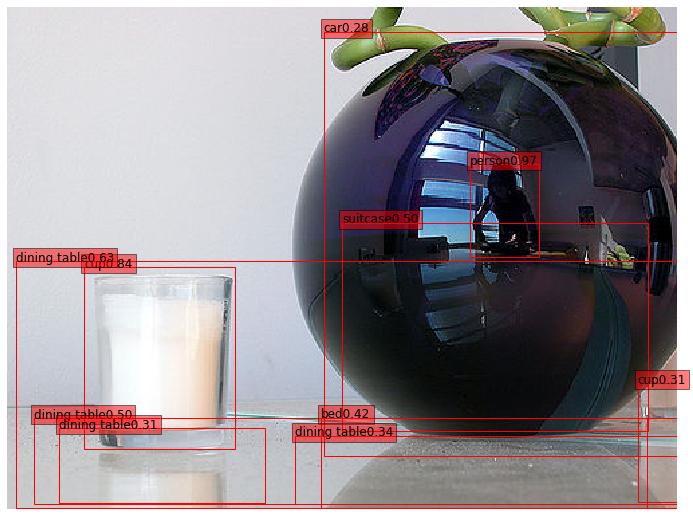

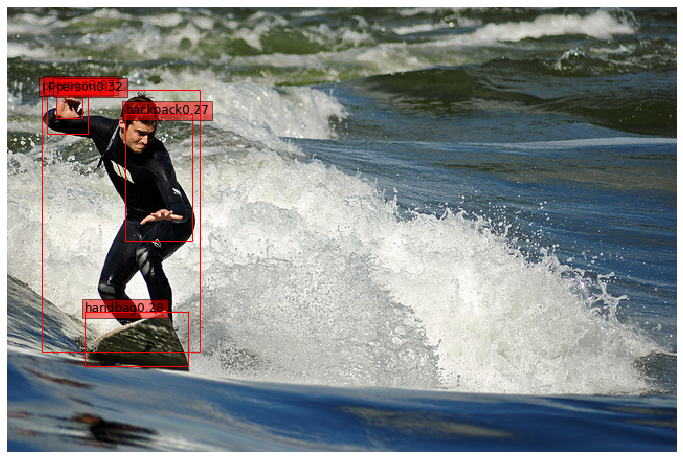

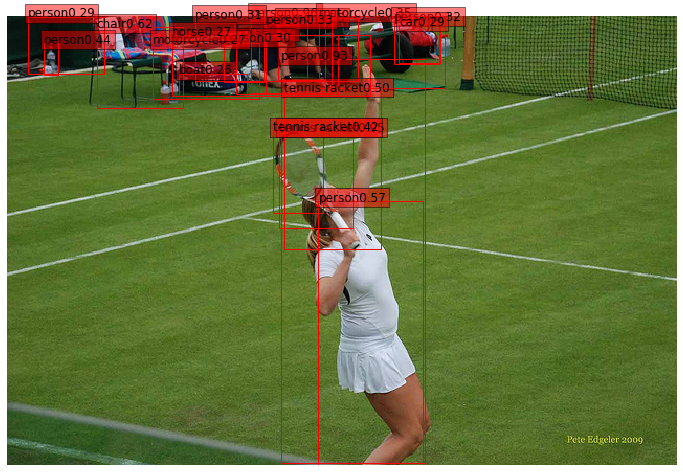

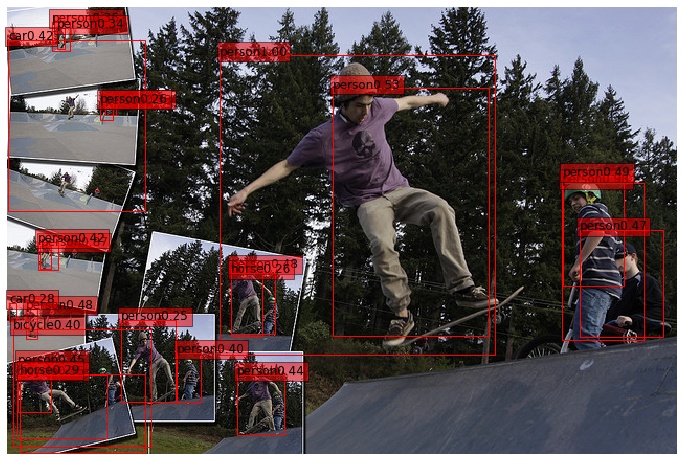

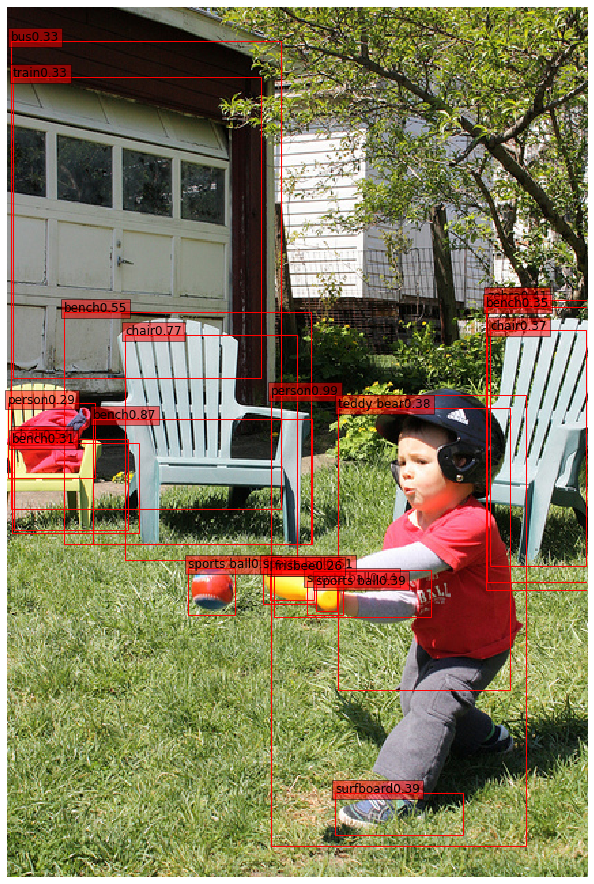

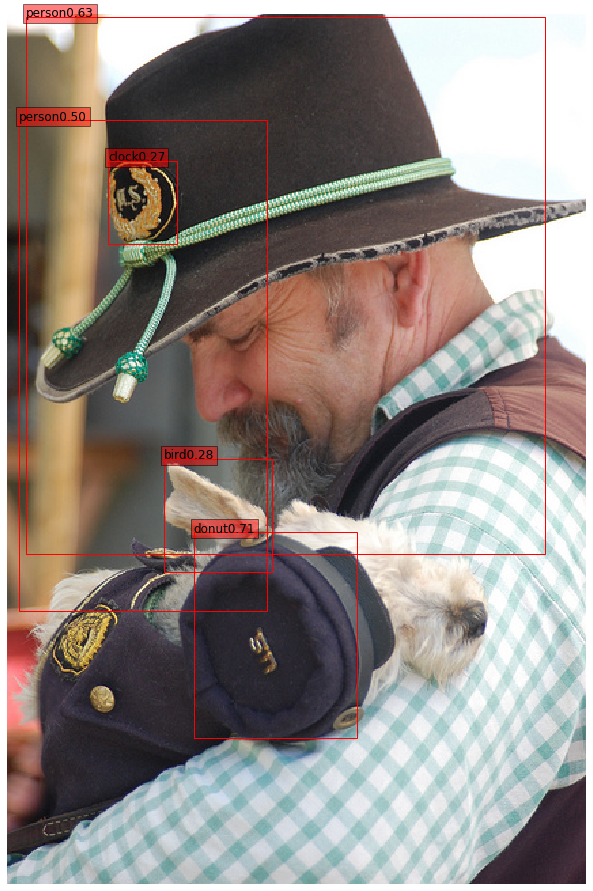

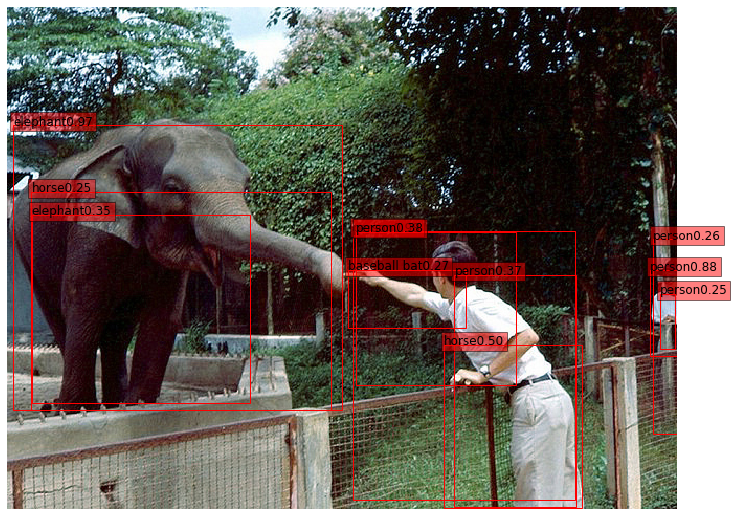

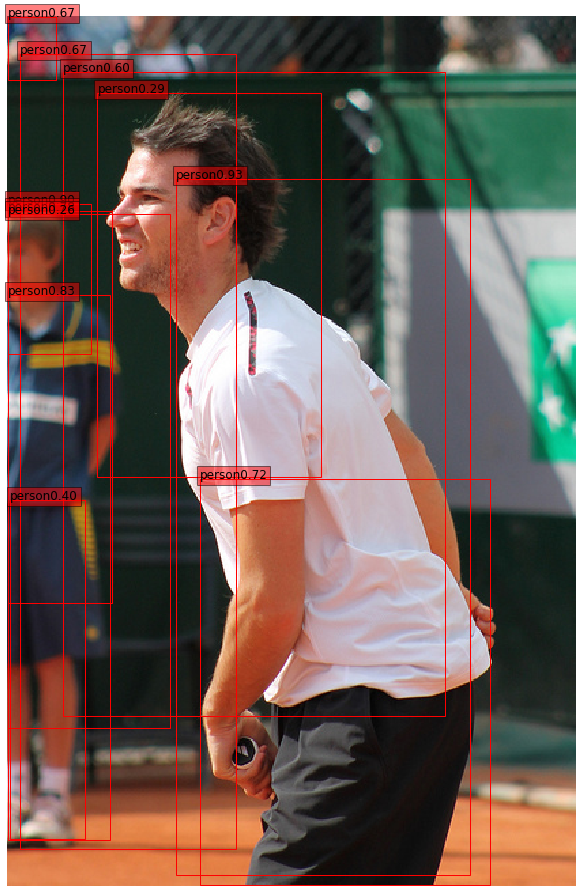

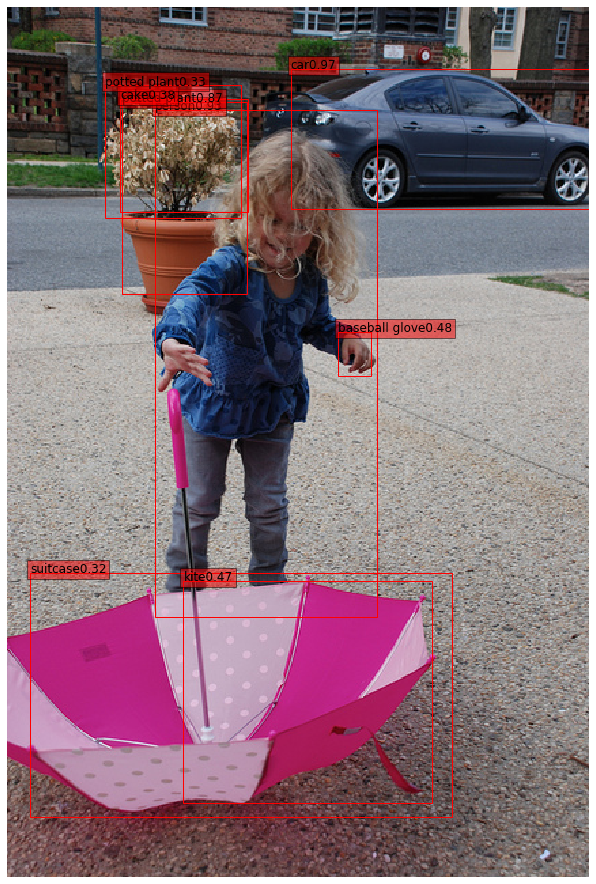

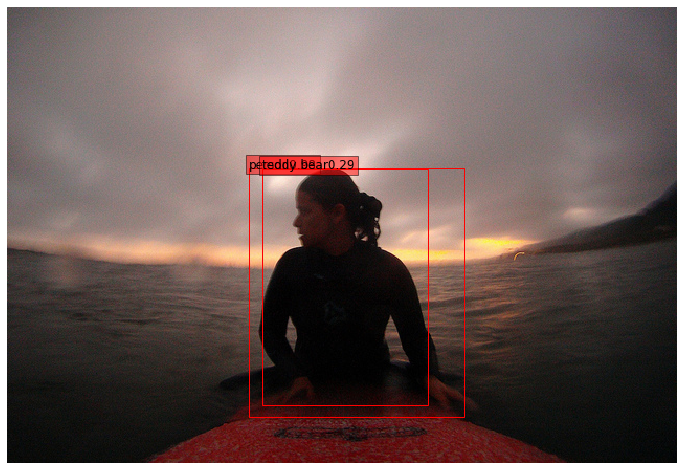

In [159]:
for i in range(10):
    img = get_coco_image_by_random(i)
    res = model(img)
    rcParams['figure.figsize'] = 12, 16
    show_result(img, res)